In [1]:
from __future__ import division
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

from performance import *

# Purpose of the Notebook

Factor Risk Parity Prototype

In [2]:
country_etfs = pd.read_csv('../Data/country_data/ETF_adj_close.csv',index_col=0)
country_etfs.index = pd.to_datetime(country_etfs.index)
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('Emerging_MOM_Factor',start = '2000-01-01').read()[0]
ff6 = pd.concat([ff5,ff_mom],axis=1)

In [3]:
# find weekly return - take last date and pct-change
country_returns = country_etfs.resample('W').last().pct_change()
# country_returns.index = country_returns.index.to_period('W')

In [4]:
equity_factors = pd.read_pickle('../Outputs/equity/equity_country_factors_rf.pkl')

equity_factors = equity_factors[equity_factors.momentum.notnull()]

# Step 1: Obtain Loading and Covariance Matrix per Cluster

In [5]:
# weeks = pd.Series(pd.period_range(start='2000-01-01', end='2020-12-31', freq='W')).rename('Week').reset_index()
# weeks['Date'] = pd.to_datetime(weeks['Week'].dt.strftime('%Y-%m'))
# weeks['Date'] = weeks['Date'].dt.to_period('M')

# ff6_monthly = ff6.copy()
# # reindex to weekly
# ff6 = ff6.reset_index().merge(weeks).set_index('Week')
# _ = ff6.pop('index')

In [6]:
rolling_betas = {}
# ff5_new = ff5.copy()
# ff5_new['Mkt'] = ff5_new['Mkt-RF'] + ff5_new['RF']
#cols = ['SMB', 'HML', 'RMW', 'CMA', 'Mkt']
factors= ['size', 'value', 'momentum', 'low_beta']

for c in country_returns:
    y = country_returns.loc[equity_factors.index][c]
    y = y*100-equity_factors['market-rf'] - equity_factors['rf']
    y = y.dropna()
    X = equity_factors.loc[y.index][factors]
    X = sm.add_constant(X, prepend=False)
    mod = RollingOLS(y, X,window=52)
    rolling_res = mod.fit(params_only = True)
    rolling_betas[c] = rolling_res.params
rolling_df = pd.concat(rolling_betas)

In [7]:
weeks_list = rolling_df.index.get_level_values(1).unique()

weekly_exposure, weekly_cov = {}, {}
factor_rolling_cov = equity_factors[factors].rolling(52, min_periods = 1).cov()
for m in weeks_list:
    week_df = rolling_df.loc[(slice(None), m), :].iloc[:,:-1]
    weekly_exposure[m] = week_df
    weekly_cov[m] = factor_rolling_cov.loc[(m,slice(None)), :]

In [8]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
#     print(J)
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

In [9]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
#     MRC = V*w.T
    # Risk Contribution
    RC = 0.075/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
#     print(J)
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

In [10]:
x_t = [0.25, 0.25, 0.25, 0.25] # risk budget percent of total portfolio risk (equal risk)
cons = ({'type': 'eq', 'fun': total_weight_constraint})
w0 = [0.022,0.022,0.022,0.022]


# weekly
# periods = pd.period_range(start='2015-09-27', end='2021-01-31', freq='W')
container = {}
for m in weekly_cov.keys():
    V = weekly_cov[m].values * 100
    if not np.any(np.isnan(V)):
        res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons)
        w = np.asmatrix(res.x)
        weights = weekly_exposure[m].values * w.T
        if not np.all(np.isnan(weights)):
            weight_df = pd.DataFrame(weights,
                                     index = weekly_exposure[m].index,
                                     columns = ['Weights']).droplevel(1,axis=0)
            container[m] = weight_df

<AxesSubplot:xlabel='level_0'>

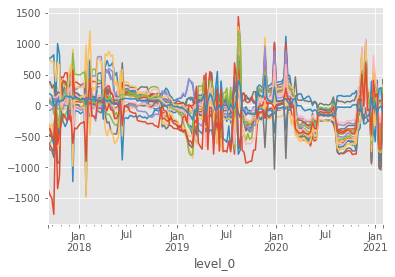

In [11]:
# unnormalized weights
rp_raw = pd.concat(container).reset_index().pivot(columns = 'level_1',index = 'level_0')
rp_raw.plot(legend = False)

In [12]:
# rp_raw = rp_raw.div(rp_raw.sum(axis=1), axis=0)
country_rp = country_returns.loc[rp_raw.index].values * rp_raw.values
country_rp = pd.DataFrame(country_rp.sum(axis=1),columns = ['risk_parity'], index = rp_raw.index)

<AxesSubplot:xlabel='level_0'>

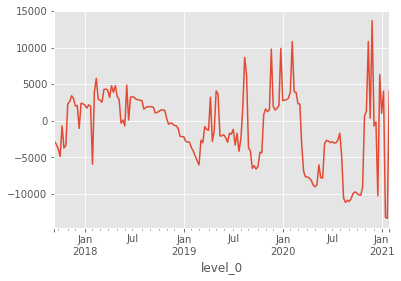

In [13]:
rp_raw.sum(axis=1).plot()

In [14]:
country_ew = country_returns.loc[rp_raw.index].mean(axis=1)
country_ew = pd.DataFrame(country_ew,columns = ['equal_weighted'], index = rp_raw.index)

## Performance

In [15]:
portfolios = country_rp.join(country_ew)

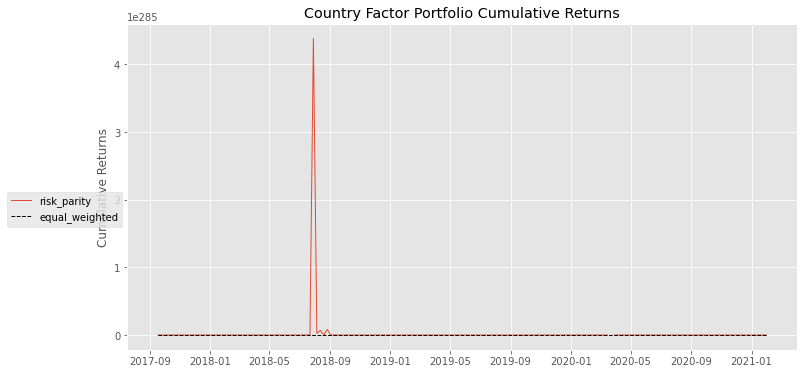

In [16]:
all_port_cum_ret_df = calc_cum_returns(portfolios)

# Plot cumulative returns
plot_perf(perf=[all_port_cum_ret_df[x] for x in list(all_port_cum_ret_df.columns.values)[:-1]], \
          perf_bm=all_port_cum_ret_df['equal_weighted_cum_ret'], label=country_rp.columns, \
          title='Country Factor Portfolio Cumulative Returns',benchmark_label='equal_weighted')

### VT stuff (unfinished)

In [17]:
class VolTargetRebalance:
    
    def __init__(self, 
                 aum, 
                 asset_names, # list of asset class names
                 returns, # dataframe of log returns with assets in same order with asset_classes
                 time, # daily return:252, weekly return:52 ...
                 target_vol, # float, in percentage, usually 10 - 15
                 burn, # number of observations to drop to smooth out impact of initial vol estimation
                 barrier=1.5, # risk control - when to switch to short vol
                 lam_short=0.98, # lambda for EWMA portfolio vol / correlation calculation
                 lam_long=0.995, # lambda for EWMA vol weight rebalance calculation
                 leverage_cap=1.5# float, only in effect for vol target funds i.e. nasset = 1 for naive rebalance
                ):
        self.aum = aum
        self.asset_names = asset_names
        self.returns = returns
        self.time = time
        self.target_vol = target_vol
        self.leverage_cap = leverage_cap
        self.lam_short = lam_short
        self.lam_long = lam_long
        self.burn = burn
        self.barrier = barrier
        
        self.nassets = len(asset_names)
        self.nt = len(returns) - burn
        if self.nassets == 1:
            self.r = returns.values.reshape(-1, 1)
        else:
            self.r = returns.values

        vols = np.empty(self.r.shape)
        for i in range(self.nassets):
            vols[:,i] = self.calc_EWMA_vol(self.r[:,i], lam_long, dataframe=False, verbose=False)
        self.vols = vols
        
    def calc_EWMA_vol(self, returns, lam, dataframe=True, verbose=True):
        r_sq = returns ** 2
        if dataframe:
            sigma_sq = pd.Series(index=r_sq.index, dtype='float64')
        else:
            sigma_sq = np.empty(len(returns))
        sigma_sq[0] =r_sq[0]
        for i in range(1, len(r_sq)):
            sigma_sq[i] = (1 - lam) * r_sq[i] + lam * sigma_sq[i - 1]
        sigma = np.sqrt(sigma_sq) * np.sqrt(self.time) * 100
        if verbose:
            print("half-life:", -np.log(2)/np.log(lam))
            print("avg annual volatility:", sigma.mean())
        return sigma

        
    def get_weights(self):
        raise NotImplementedError
        
    def get_flow(self, threshold_small=0.01, threshold_big=0.2):
        target_weights = self.get_weights()
        RP_k = np.empty(target_weights[:-1].shape)
        RP_fund = np.empty(RP_k.shape[0])
        trade = np.empty(target_weights[:-1].shape)
        NAV = np.empty((self.nt, 1))
        NAV[0] = self.aum
        RP_k[0] = np.multiply(target_weights[0], self.r[self.burn + 1])
        RP_fund[0] = RP_k[0].sum()
        real_weights = target_weights.copy()

        for i in range(1, self.nt - 1):

            NAV[i] = NAV[i - 1] * (1 + RP_fund[i - 1])
            postTradePos = target_weights[i] * NAV[i]
            preTradePos = real_weights[i - 1] * NAV[i - 1] * (1 + self.r[self.burn + i])
            trade[i - 1] = postTradePos - preTradePos
            trade_weight = trade[i - 1] / (NAV[i] * target_weights[i])

            if np.all(np.abs(trade_weight) <= threshold_small):
                real_weights[i] = target_weights[i - 1] * (1 + self.r[self.burn + i])
                trade[i - 1] = 0
            elif np.any(np.abs(trade_weight) >= threshold_big):
                trade[i - 1] = trade[i - 1] / (max(np.abs(trade_weight)) / 0.1)
                real_weights[i] = (trade[i - 1] + preTradePos) / NAV[i]

            RP_k[i] = np.multiply(real_weights[i], self.r[self.burn + i + 1])
            RP_fund[i] = RP_k[i].sum()
        
        NAV[-1] = NAV[-2] * (1 + RP_fund[-1])
        postTradePos_last = target_weights[-1] * NAV[-1]
        preTradePos_last = real_weights[-2] * NAV[-2] * (1 + self.r[-1])
        trade[-1] = postTradePos_last - preTradePos_last
        if np.all(np.abs(trade[-1] / NAV[-1]) <= threshold_small):
            real_weights[-1] = target_weights[-2] * (1 + self.r[-1])
            trade[-1] = 0
        
        df_trade = pd.DataFrame(data=trade, index=self.returns[self.burn+1:].index, columns=self.asset_names)
        df_trade_pct = df_trade / NAV[1:]
        df_weights = pd.DataFrame(data=np.c_[target_weights[:-1], real_weights[:-1]], index=self.returns[self.burn+1:].index, columns=[x + y for x in ['target_', 'real_'] for y in self.asset_names])
        df_returns = pd.DataFrame(data=RP_fund, index=self.returns[self.burn+1:].index, columns=['fund_return'])
 
        return df_trade, df_trade_pct, df_weights, df_returns
        
class NaiveRebalance(VolTargetRebalance):
    
    def get_weights(self):
        weights = self.target_vol / self.nassets / self.vols[self.burn:]
        weights = np.atleast_2d(weights)

        realized_vol = np.empty(self.nt)
        ratio = np.empty(self.nt)
        for i in range(self.nt):
            portfolio_returns = self.r[:self.burn + i + 1] @ weights[i, :]
            short_vol = self.calc_EWMA_vol(portfolio_returns, self.lam_short, dataframe=False, verbose=False)[-1]
            long_vol = self.calc_EWMA_vol(portfolio_returns, self.lam_long, dataframe=False, verbose=False)[-1]
            ratio[i] = short_vol / long_vol
            realized_vol[i] = long_vol if ratio[i] < self.barrier else short_vol

        plt.plot(self.returns[self.burn:].index, ratio, label=r'$\lambda^s$={}, $\lambda^l$={}'.format(self.lam_short, self.lam_long))
        plt.legend()                             
        plt.title('Ratio between EWMA Portfolio Vol with $\lambda$ = {} vs EWMA Portfolio Vol with $\lambda$ = {}'.format(self.lam_short, self.lam_long))
        
        leverage = self.target_vol / realized_vol
        weights_rescaled = np.multiply(weights, leverage.reshape(-1, 1))
        if self.nassets == 1:
            weights_rescaled[weights_rescaled > self.leverage_cap] = self.leverage_cap
        return weights_rescaled
    
class HistCorrRebalance(VolTargetRebalance):
    
    def _get_portfolio_risk(self, weights, cov):
        weights = np.matrix(weights)
        return np.sqrt((weights * cov * weights.T))[0, 0]

    def _get_risk_contribution(self, weights, cov):
        weights = np.matrix(weights)
        portfolio_risk = self._get_portfolio_risk(weights, cov)
        return np.multiply(weights.T, cov * weights.T) / portfolio_risk ** 2

    def _risk_budget_objective_error(self, weights, args):
        cov = args[0]
        assets_risk_budget = args[1]
        weights = np.matrix(weights)
        portfolio_risk = self._get_portfolio_risk(weights, cov)
        assets_risk_contribution = self._get_risk_contribution(weights, cov)
        assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))
        return sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    def _get_risk_parity_weights(self, cov, assets_risk_budget, initial_weights):
        constraints = ({'type': 'eq', 'fun': lambda x: self._get_portfolio_risk(x, cov) - self.target_vol / 100},
                       {'type': 'ineq', 'fun': lambda x: x})
        optimize_result = minimize(fun=self._risk_budget_objective_error, x0=initial_weights, args=[cov, assets_risk_budget], \
                                   method='SLSQP', tol=1e-10, constraints=constraints, options={'disp': False})
        weights = optimize_result.x
        return weights

    def get_weights(self):
        weights = np.empty((self.nt, self.nassets))
        for i in range(self.nt):
            weights[i,:] = self._get_risk_parity_weights(self.returns[i:self.burn+i].cov().values * self.time, [0.25,0.25,0.25,0.25], [0.25,0.25,0.25,0.25])
        return weights

In [18]:
rp_rebal = HistCorrRebalance(1, asset_names=factors, returns=equity_factors[factors], time=52, target_vol=5, lam_short=0.7, lam_long=0.83, burn=12, barrier=1.5)

In [19]:
rp_trade, rp_trade_pct, rp_weight, rp_returns = rp_rebal.get_flow()

<AxesSubplot:>

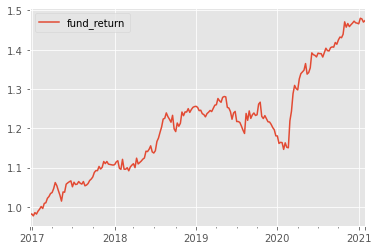

In [20]:
(1 + rp_returns).cumprod().plot()

In [21]:
rp_rebal_ = NaiveRebalance(1, asset_names=factors, returns=equity_factors[factors], time=52, target_vol=5, lam_short=0.7, lam_long=0.83, burn=12, barrier=1.5)

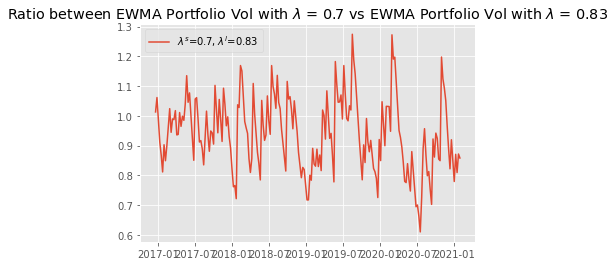

In [22]:
rp_trade_, rp_trade_pct_, rp_weight_, rp_returns_ = rp_rebal_.get_flow()

<AxesSubplot:>

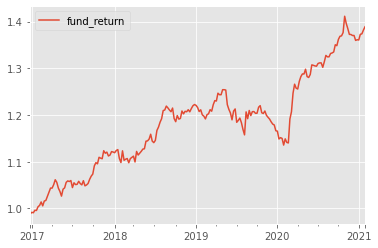

In [23]:
(1 + rp_returns_).cumprod().plot()

In [24]:
realized_weights_cols = ['real_' + x for x in factors]

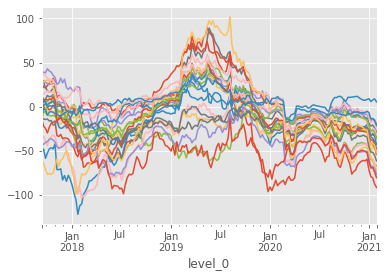

In [25]:
container_naive = {}
weeks_in_common = set(weekly_cov.keys()).intersection(rp_weight_.index)

for m in weeks_in_common:
    
        factor_weights = rp_weight_[realized_weights_cols].loc[m].values
        country_weights = weekly_exposure[m].values @ factor_weights.T
        if not np.all(np.isnan(country_weights)):
            weight_df = pd.DataFrame(country_weights, index = weekly_exposure[m].index, columns = ['Weights']).droplevel(1,axis=0)
            container_naive[m] = weight_df



# unnormalized weights
rp_raw_naive = pd.concat(container_naive).reset_index().pivot(columns = 'level_1',index = 'level_0')
rp_raw_naive.plot(legend = False)

rp_raw_naive = rp_raw_naive.div(rp_raw_naive.sum(axis=1), axis=0)
country_rp_naive = country_returns.loc[rp_raw_naive.index].values * rp_raw_naive.values
country_rp_naive = pd.DataFrame(country_rp_naive.sum(axis=1),columns = ['risk_parity'], index = rp_raw_naive.index)

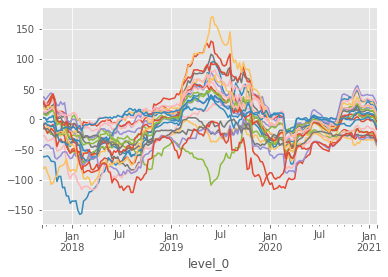

In [26]:
container_histcorr = {}
weeks_in_common = set(weekly_cov.keys()).intersection(rp_weight.index)

for m in weeks_in_common:
    
        factor_weights = rp_weight[realized_weights_cols].loc[m].values
        country_weights = weekly_exposure[m].values @ factor_weights.T
        if not np.all(np.isnan(country_weights)):
            weight_df = pd.DataFrame(country_weights, index = weekly_exposure[m].index, columns = ['Weights']).droplevel(1,axis=0)
            container_histcorr[m] = weight_df



# unnormalized weights
rp_raw_histcorr = pd.concat(container_histcorr).reset_index().pivot(columns = 'level_1',index = 'level_0')
rp_raw_histcorr.plot(legend = False)

rp_raw_histcorr = rp_raw_histcorr.div(rp_raw_histcorr.sum(axis=1), axis=0)
country_rp_histcorr = country_returns.loc[rp_raw_histcorr.index].values * rp_raw_histcorr.values
country_rp_histcorr = pd.DataFrame(country_rp_histcorr.sum(axis=1),columns = ['risk_parity'], index = rp_raw_histcorr.index)

In [27]:
portfolios = portfolios.join(country_rp_naive, rsuffix='_naive_method')
portfolios = portfolios.join(country_rp_histcorr, rsuffix='_histcorr_method')

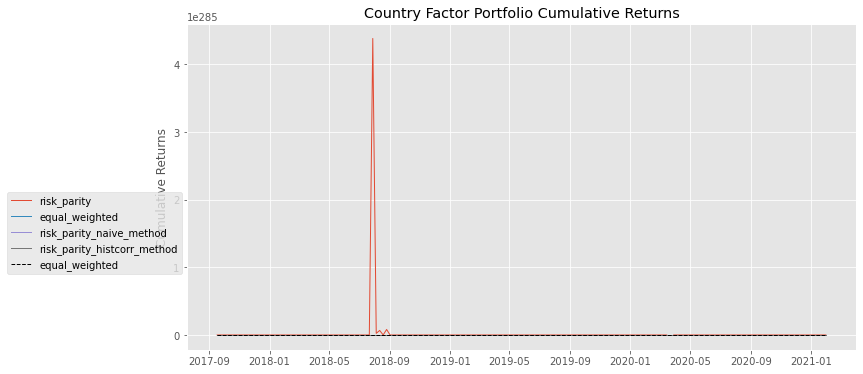

In [28]:
all_port_cum_ret_df = calc_cum_returns(portfolios)

# Plot cumulative returns
plot_perf(perf=[all_port_cum_ret_df[x] for x in list(all_port_cum_ret_df.columns.values)], \
          perf_bm=all_port_cum_ret_df['equal_weighted_cum_ret'], label=portfolios.columns, \
          title='Country Factor Portfolio Cumulative Returns',benchmark_label='equal_weighted')